In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
import pack_ga
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
local
stop final relax at some point


stop final relax at some point


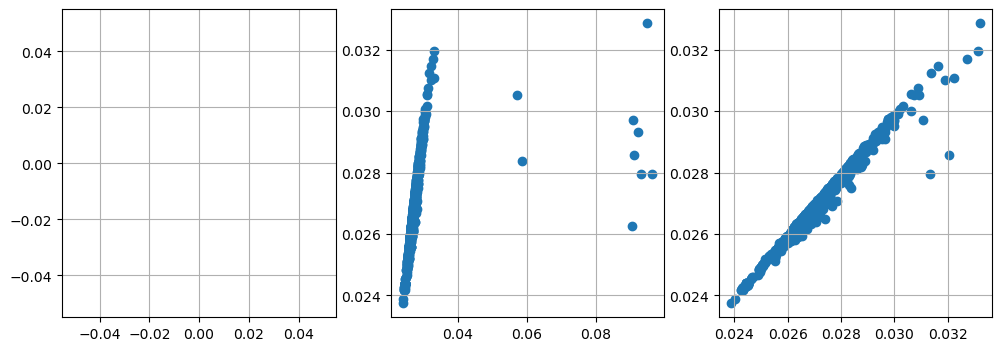

Generation 0, Trees 6, Best cost: 0.02374092, Est: 0.39568198, h: 1.526805


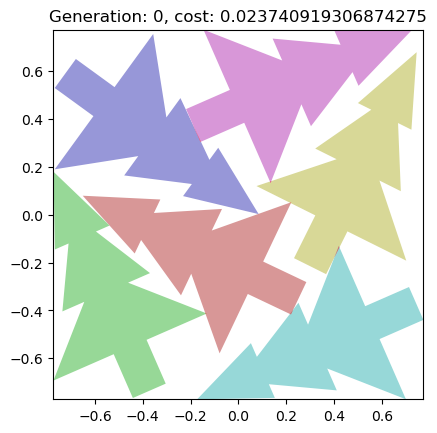

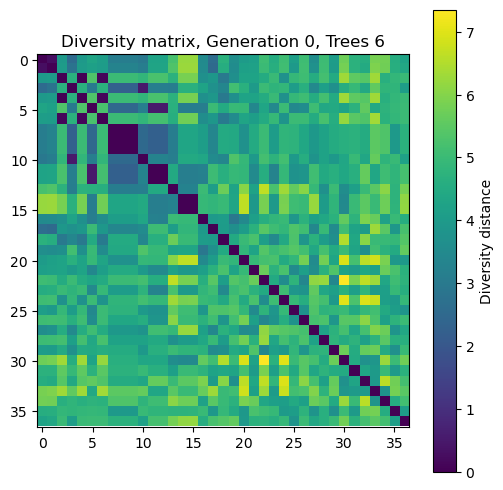

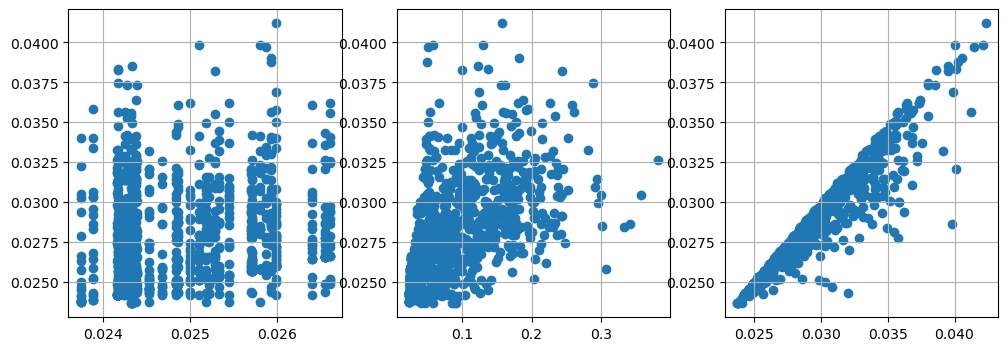

Generation 1, Trees 6, Best cost: 0.02365398, Est: 0.39423299, h: 1.527658


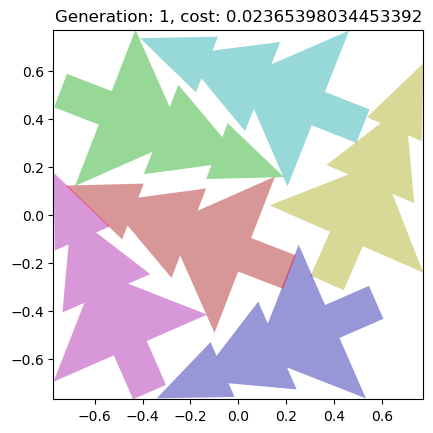

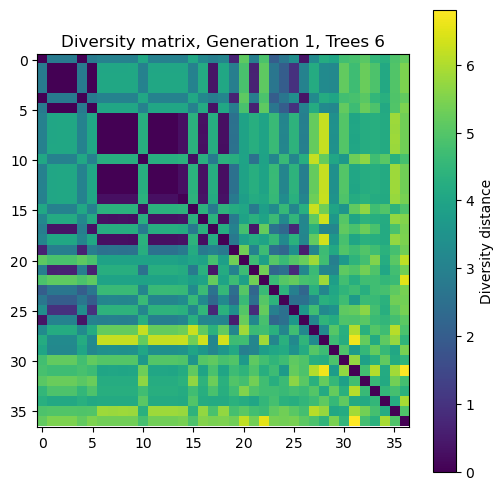

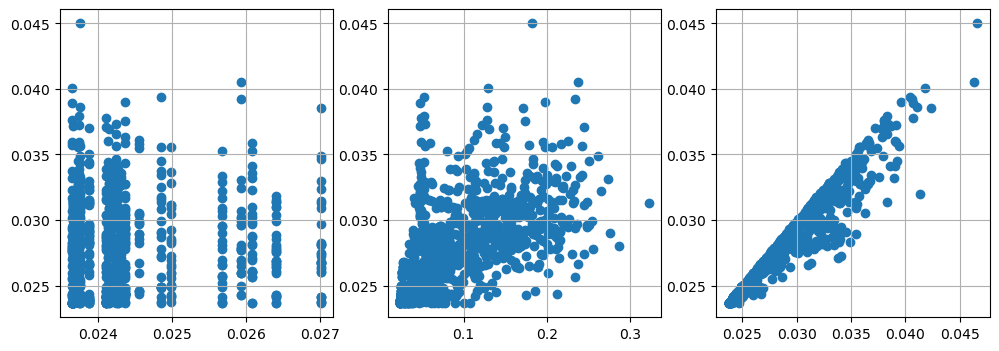

Generation 2, Trees 6, Best cost: 0.02365192, Est: 0.39419862, h: 1.527622


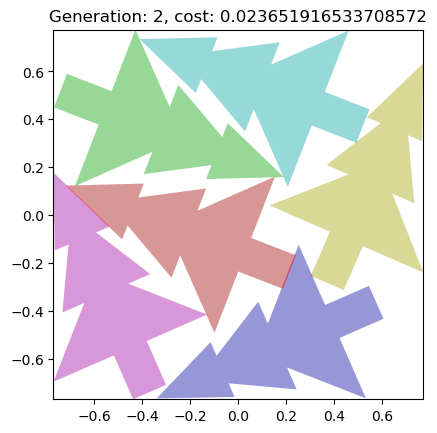

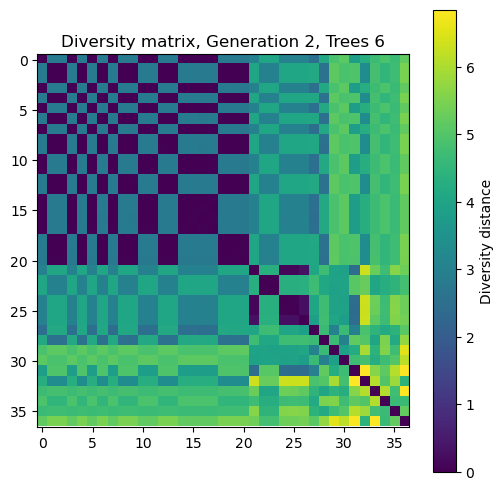

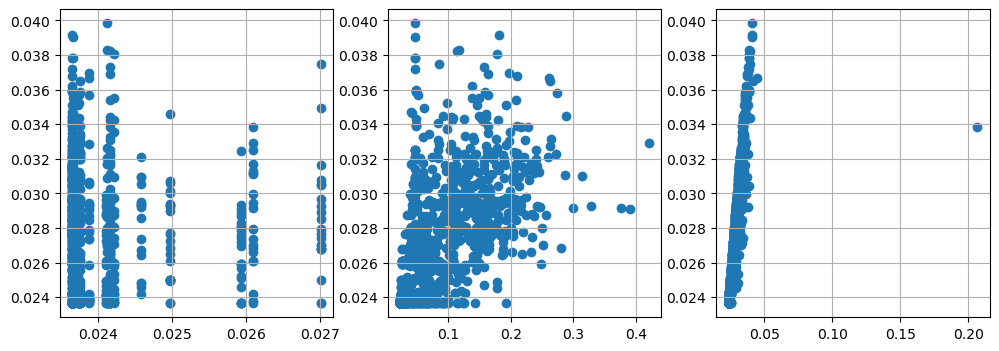

Generation 3, Trees 6, Best cost: 0.02365037, Est: 0.39417283, h: 1.527629


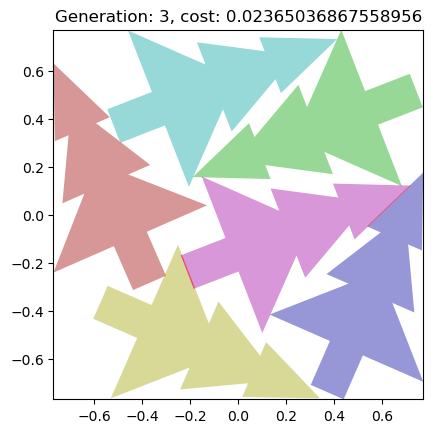

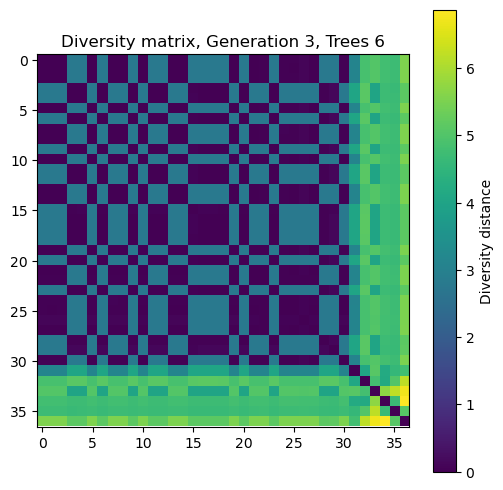

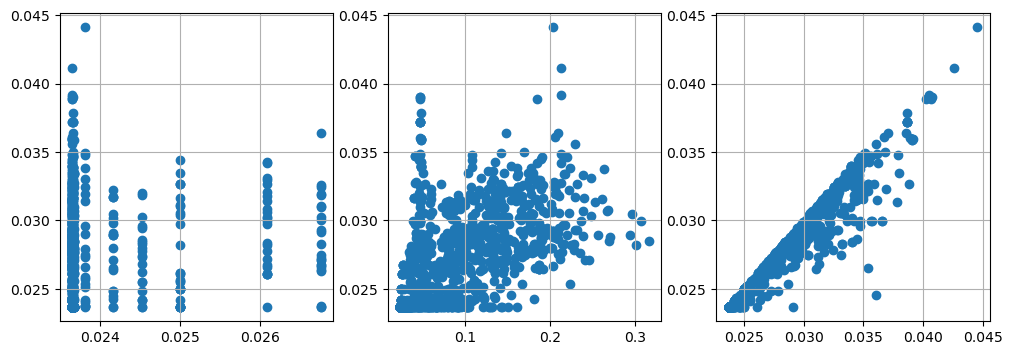

Generation 4, Trees 6, Best cost: 0.02365037, Est: 0.39417283, h: 1.527629


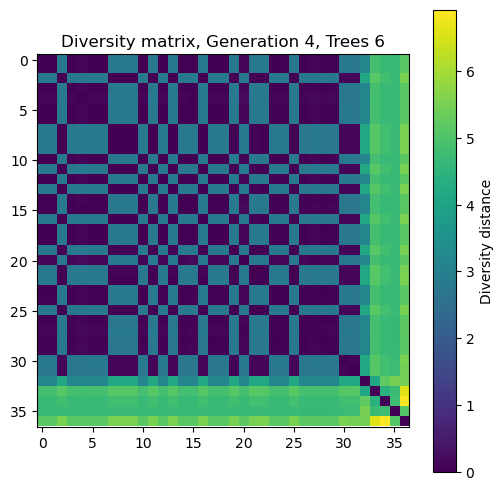

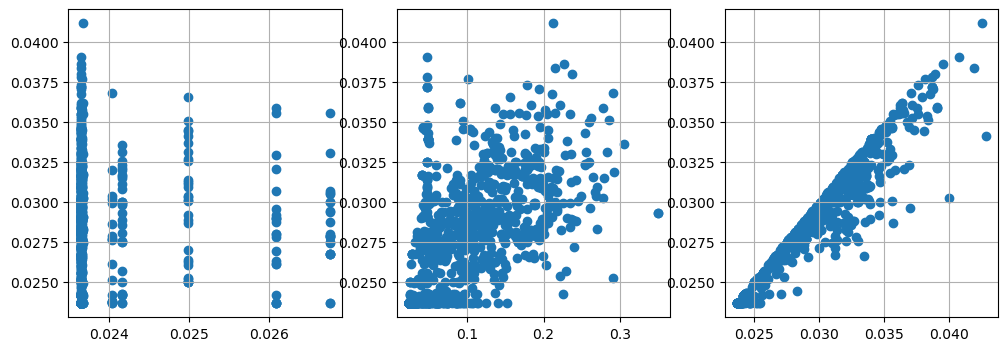

Generation 5, Trees 6, Best cost: 0.02365037, Est: 0.39417283, h: 1.527629


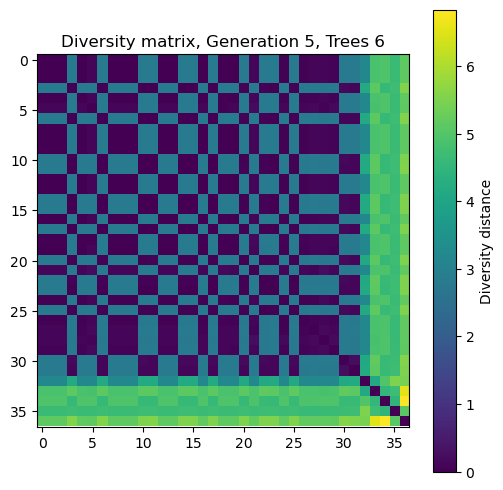

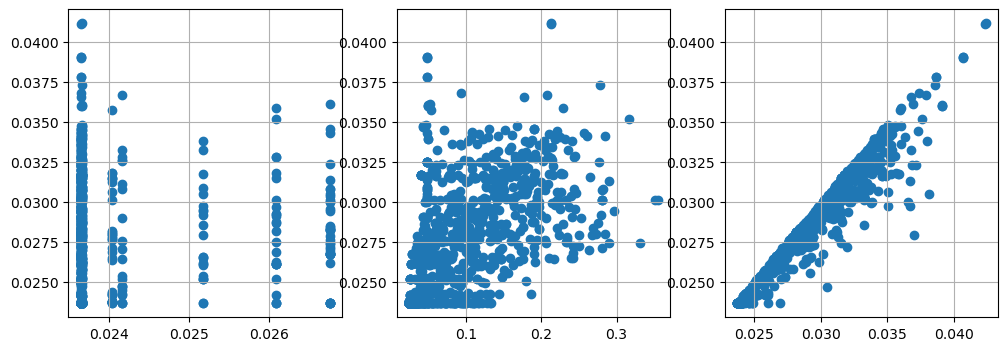

Generation 6, Trees 6, Best cost: 0.02365037, Est: 0.39417283, h: 1.527629


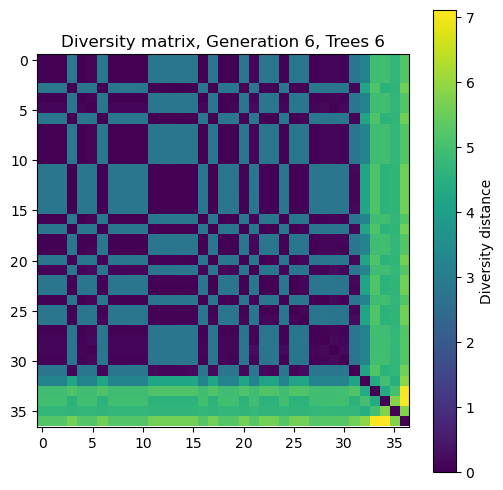

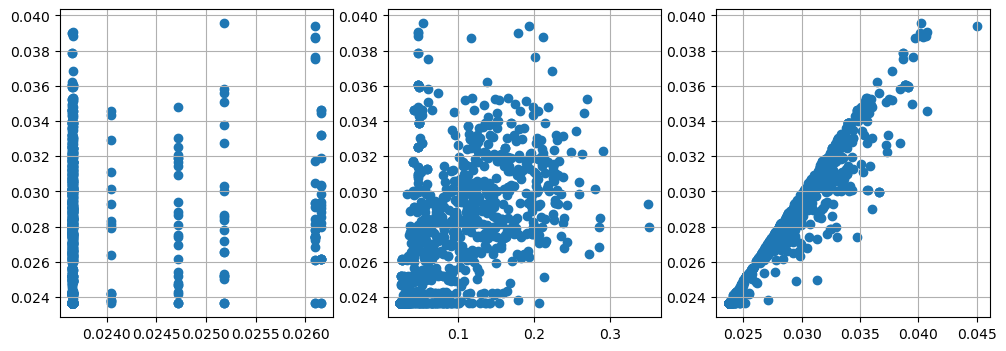

Generation 7, Trees 6, Best cost: 0.02365037, Est: 0.39417283, h: 1.527629


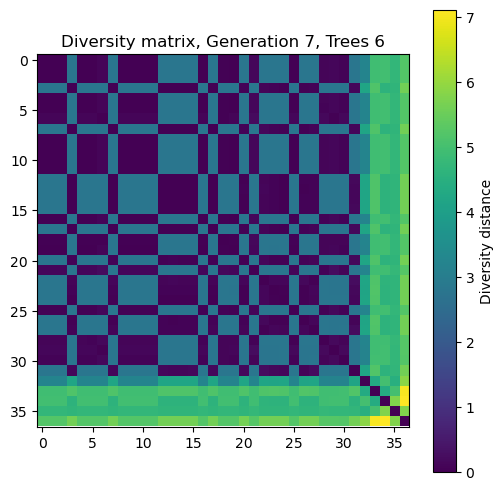

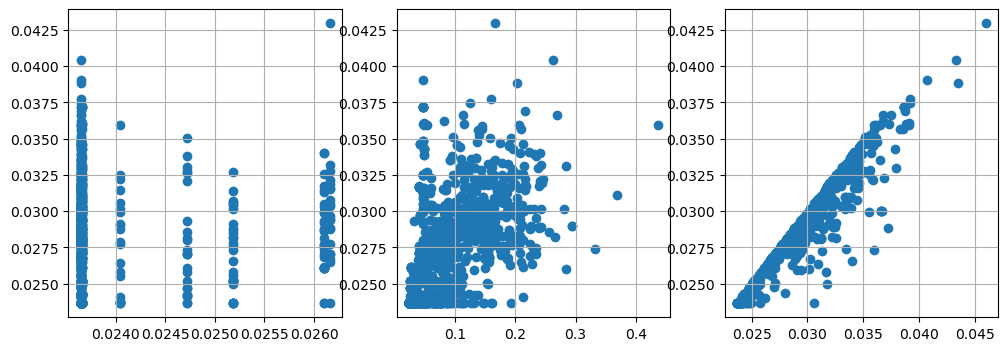

Generation 8, Trees 6, Best cost: 0.02365037, Est: 0.39417283, h: 1.527629


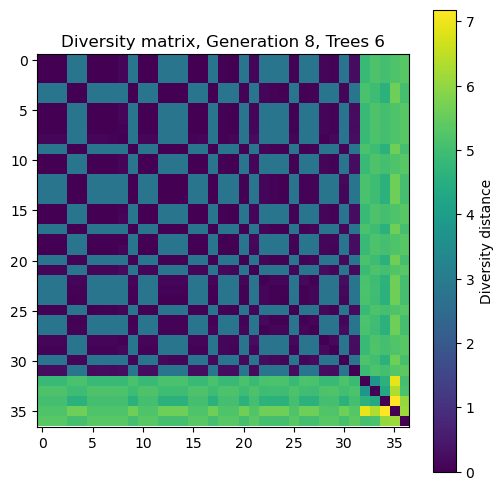

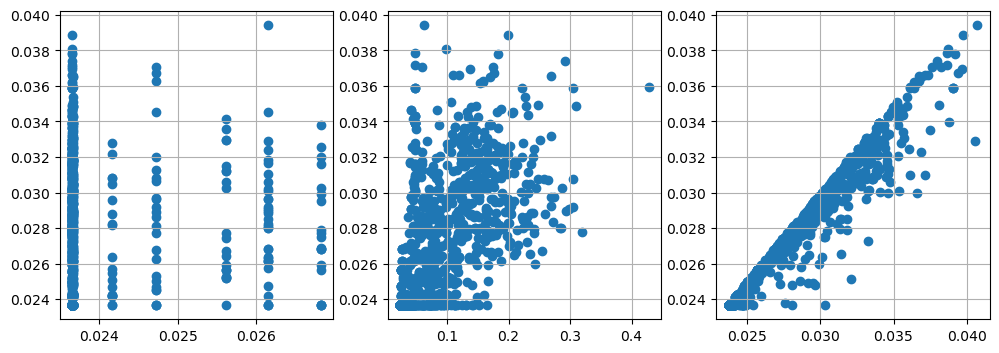

Generation 9, Trees 6, Best cost: 0.02365025, Est: 0.39417084, h: 1.527645


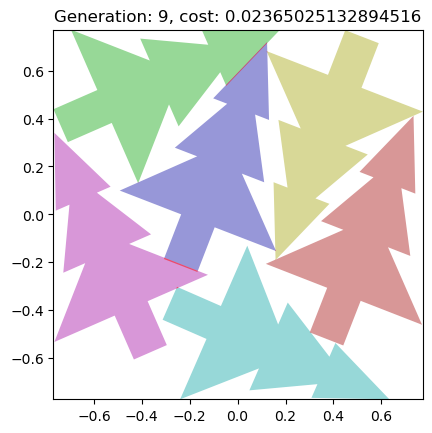

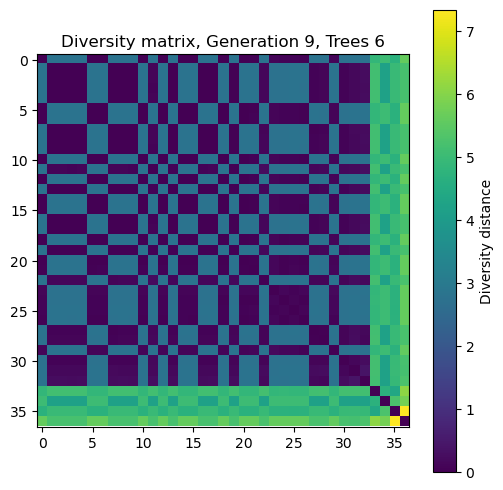

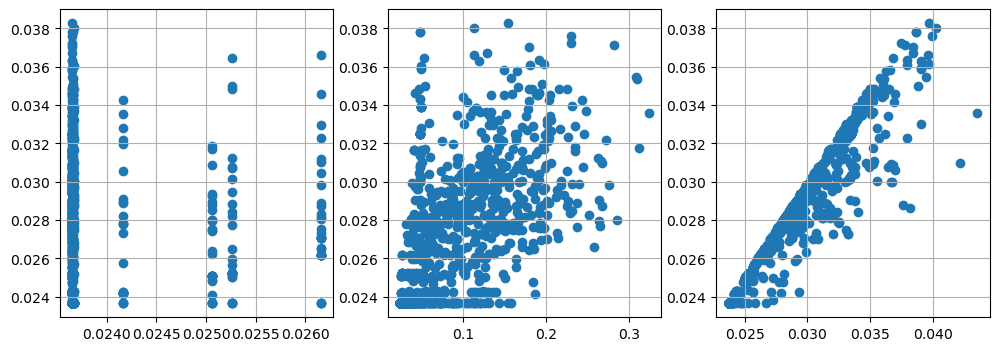

Generation 10, Trees 6, Best cost: 0.02365025, Est: 0.39417084, h: 1.527645


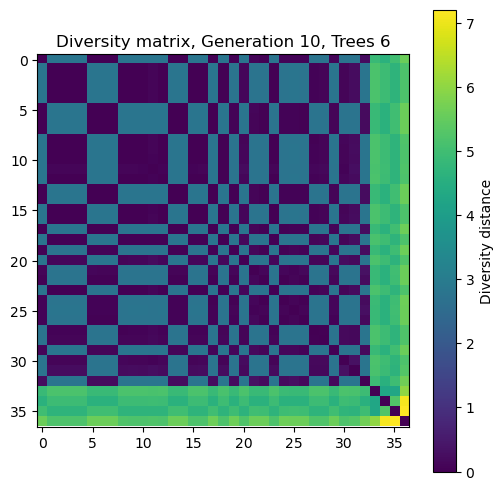

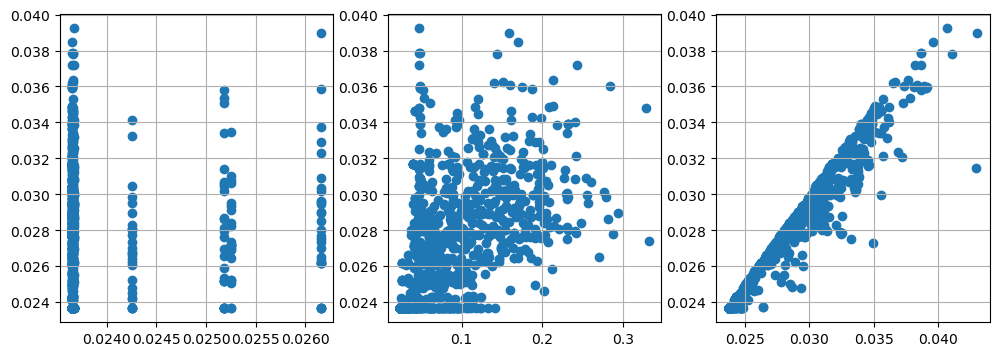

Generation 11, Trees 6, Best cost: 0.02364997, Est: 0.39416619, h: 1.527646


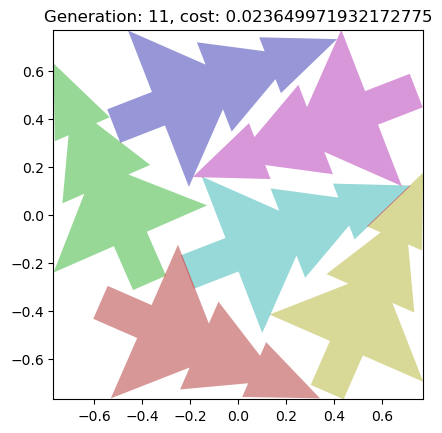

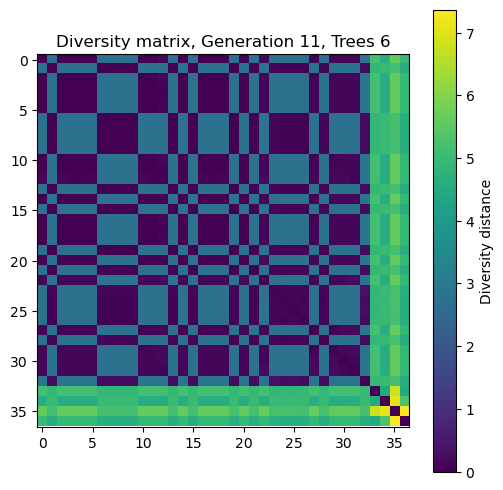

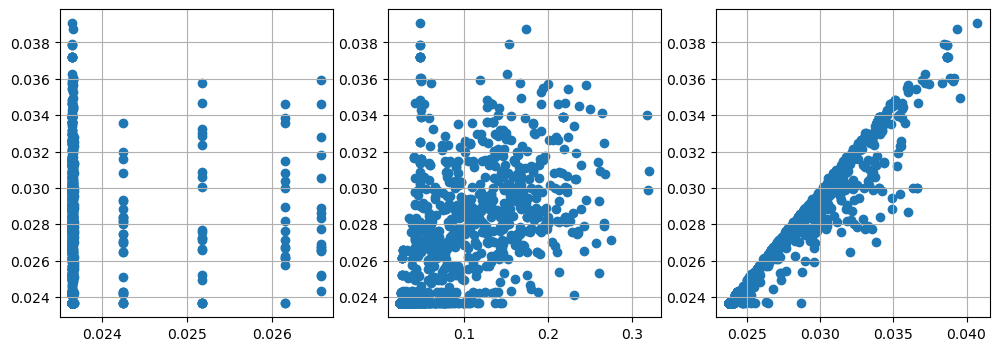

Generation 12, Trees 6, Best cost: 0.02364997, Est: 0.39416619, h: 1.527646


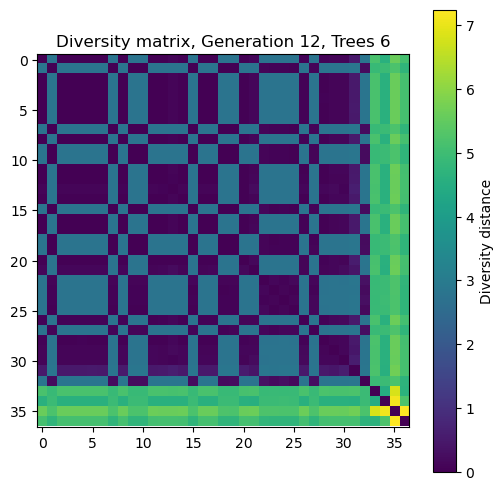

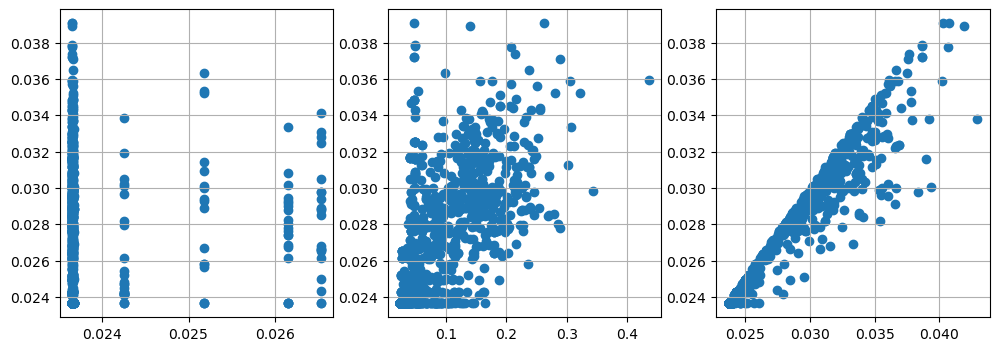

Generation 13, Trees 6, Best cost: 0.02364997, Est: 0.39416619, h: 1.527646


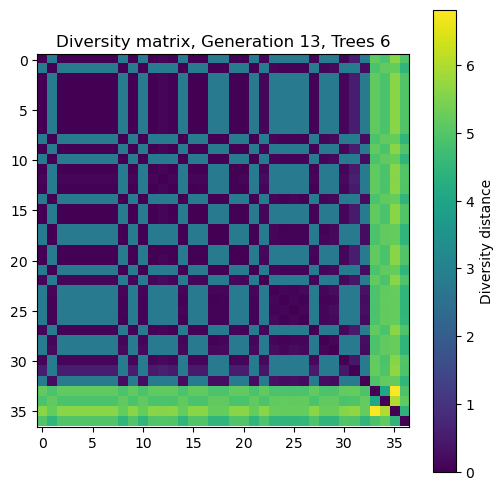

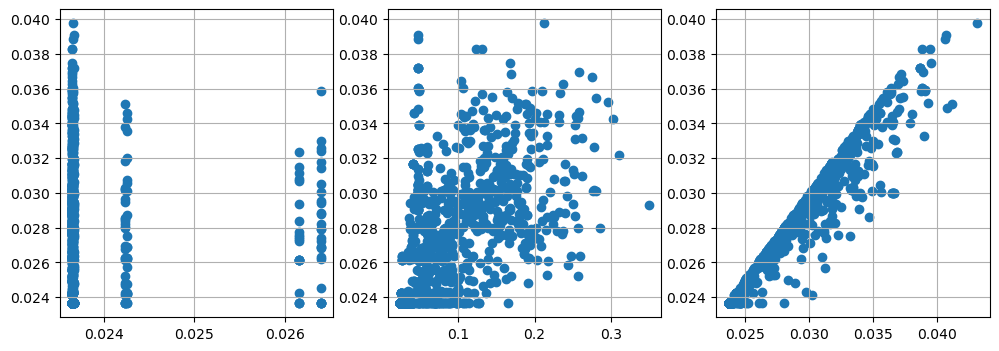

Generation 14, Trees 6, Best cost: 0.02364997, Est: 0.39416619, h: 1.527646


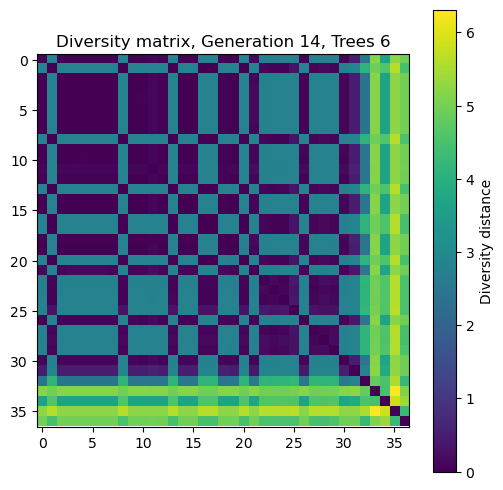

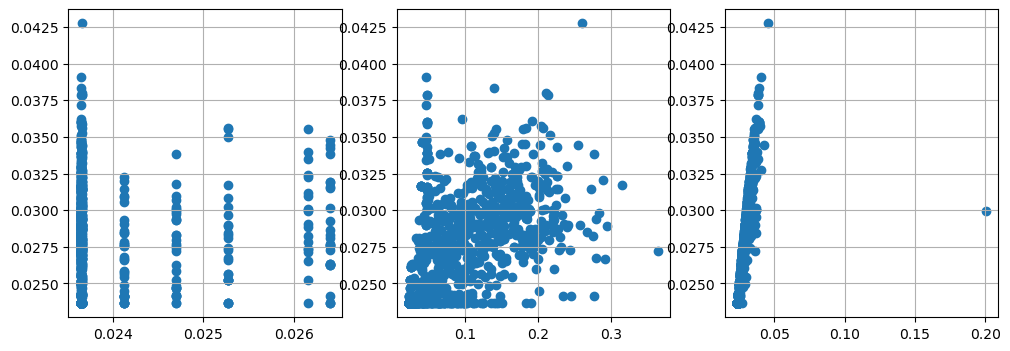

Generation 15, Trees 6, Best cost: 0.02364997, Est: 0.39416619, h: 1.527646


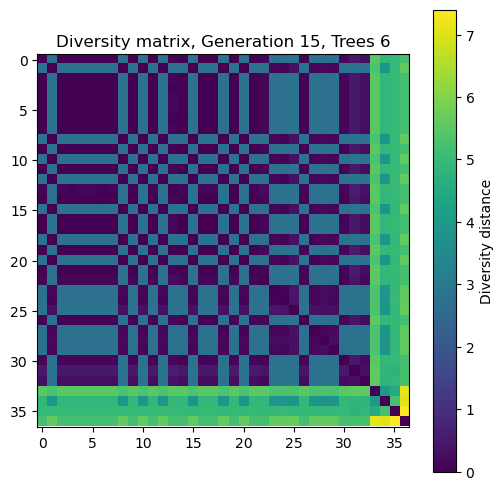

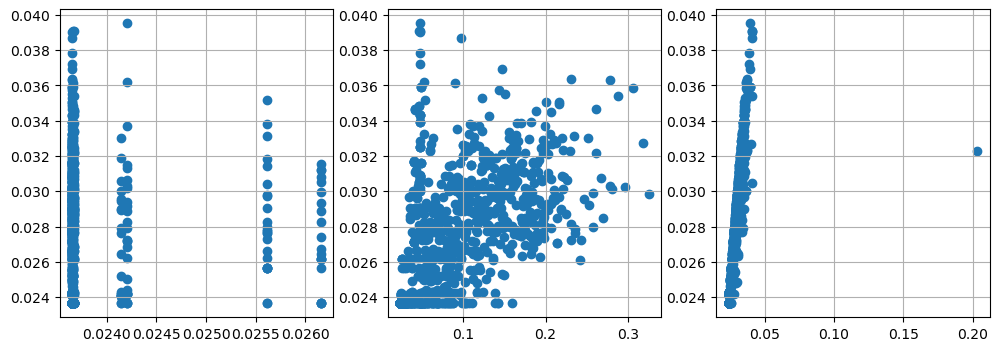

Generation 16, Trees 6, Best cost: 0.02364997, Est: 0.39416619, h: 1.527646


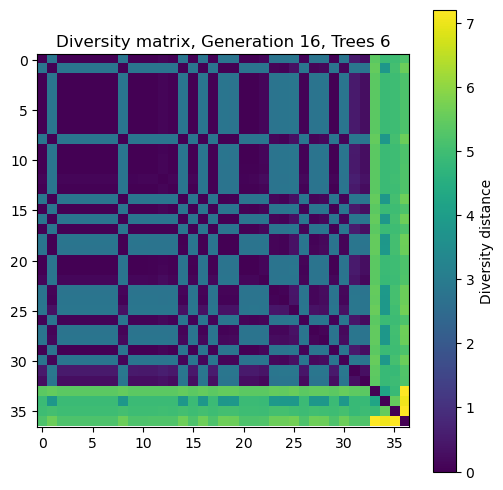

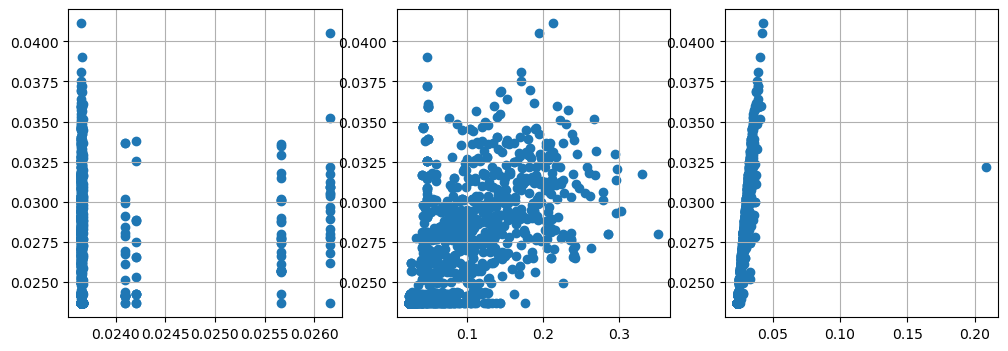

Generation 17, Trees 6, Best cost: 0.02364997, Est: 0.39416619, h: 1.527646


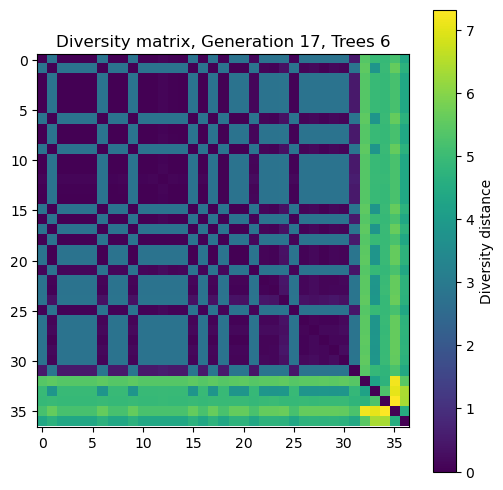

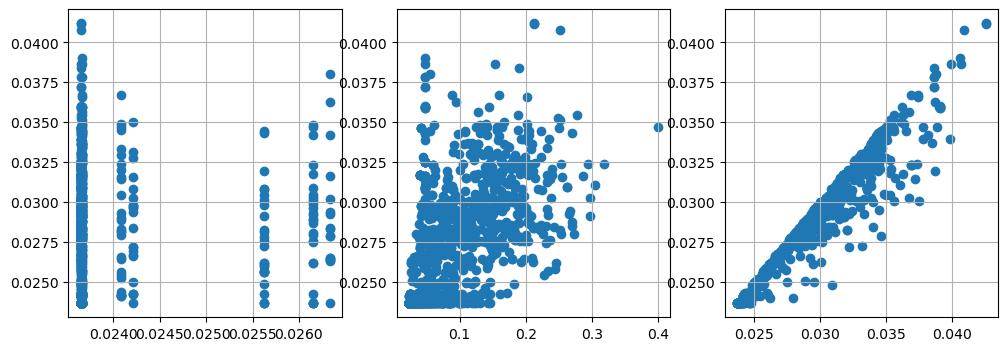

Generation 18, Trees 6, Best cost: 0.02364997, Est: 0.39416619, h: 1.527646


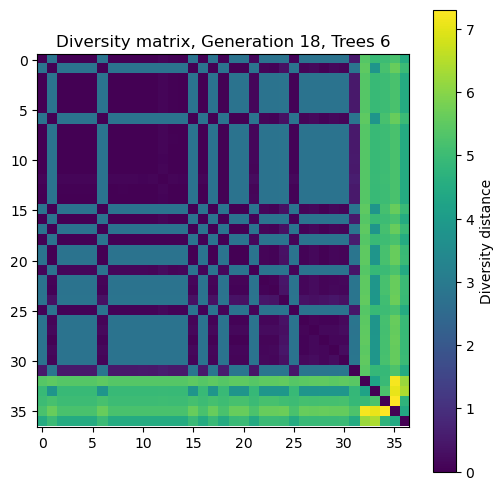

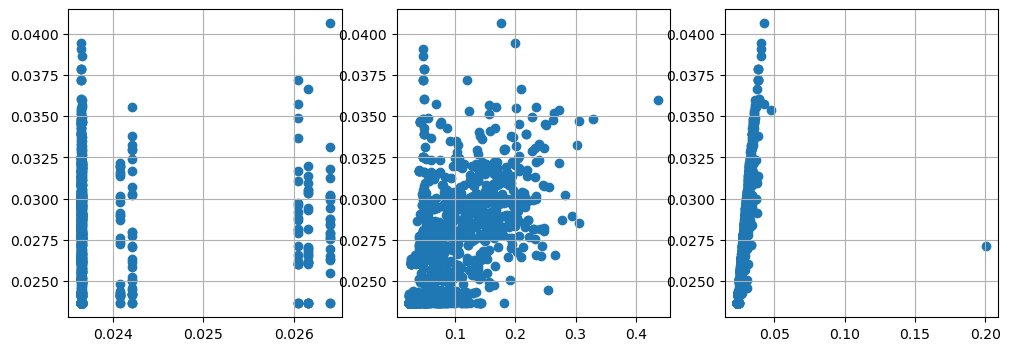

Generation 19, Trees 6, Best cost: 0.02364997, Est: 0.39416619, h: 1.527646


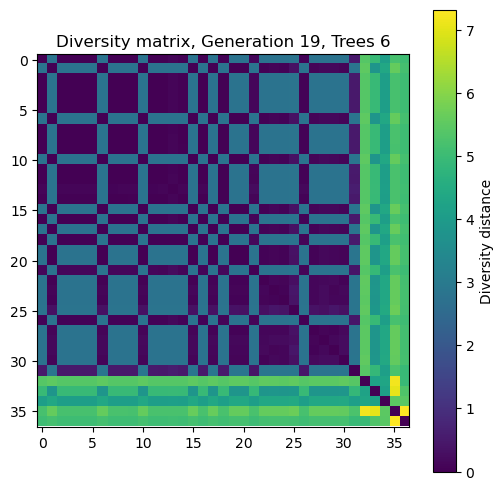

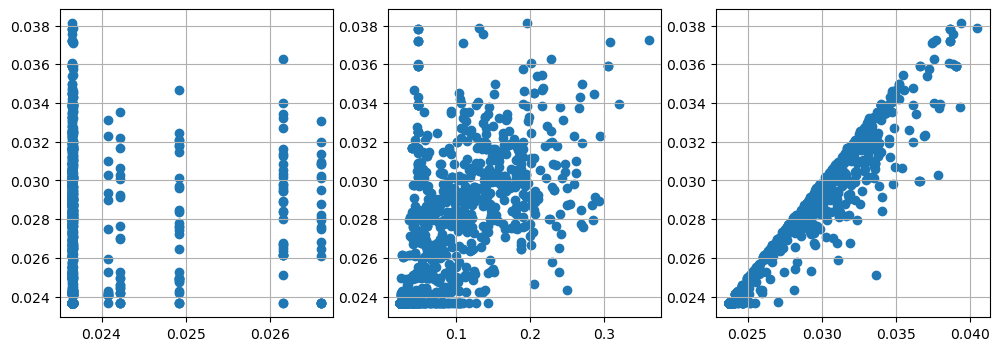

In [2]:
importlib.reload(pack_ga)
fastMode = False
runner = pack_ga.GA()
runner.N_trees_to_do = np.array([6])
runner.plot_fitness_predictors = True
runner.plot_diversity_matrix = True
runner.n_generations = 20
#runner.selection_size = [1,2]
if fastMode:
    runner.initializer.jiggler.duration_compact /= 10
    runner.initializer.jiggler.plot_interval = None
    runner.initializer.jiggler.n_rounds = 1    
    runner.rough_relaxers[0].n_iterations= 0
    runner.fine_relaxers = []
    runner.n_generations = 5
    runner.population_size = 100
    runner.selection_size = [1,2,5,10]
    kgs.debugging_mode = 2
kgs.profiling=False
runner.run()

[0.02364997] [0.02364997] 1.5276458
[0.02364997] [0.02393467] 1.5432369
[0.00011887]
0 [0.00032502]
1 [8.24441e-05]
2 [2.0739457e-05]
3 [5.1951724e-06]
4 [1.3073604e-06]
5 [3.3368556e-07]
6 [8.407274e-08]
7 [2.0703403e-08]
8 [5.143929e-09]
9 [1.2592534e-09]
[1.2592534e-09]
[0.02397543] 1.5484003 0.39959058


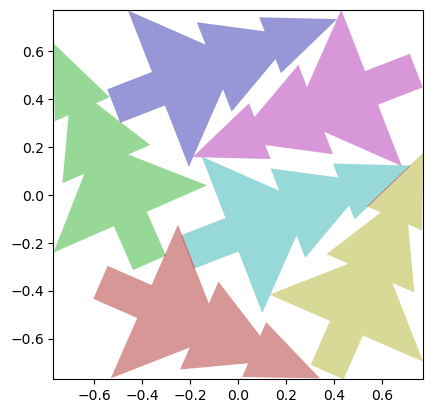

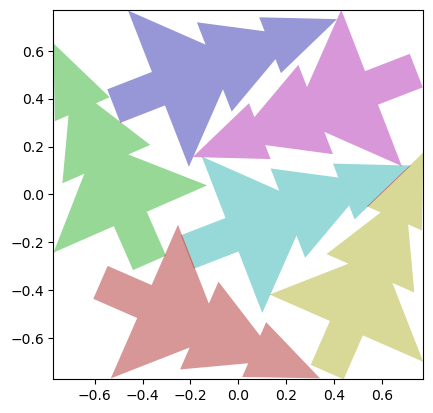

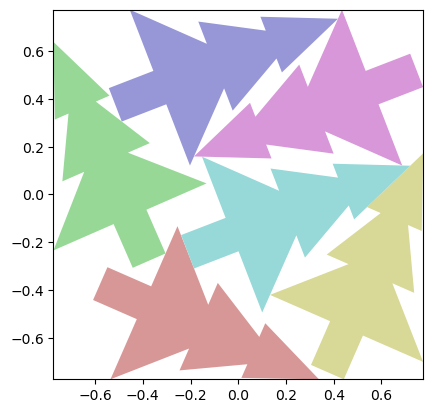

In [3]:
id = np.argmin(runner.populations[0].fitness)
sol_best =  copy.deepcopy(runner.populations[0])
sol_best.select_ids([id])
print(sol_best.fitness, runner.fitness_cost.compute_cost_allocate(sol_best.configuration)[0].get(), sol_best.configuration.h[0,0])
tree_list = kgs.TreeList()
tree_list.xyt = sol_best.configuration.xyt[0].get()
pack_vis.visualize_tree_list(tree_list)
sol_best.configuration.snap()
tree_list = kgs.TreeList()
tree_list.xyt = sol_best.configuration.xyt[0].get()
pack_vis.visualize_tree_list(tree_list)
print(sol_best.fitness, runner.fitness_cost.compute_cost_allocate(sol_best.configuration)[0].get(), sol_best.configuration.h[0,0])
cost0 = copy.deepcopy(runner.fine_relaxers[0].cost)
cost0.costs[0].scaling = 0.
print(cost0.compute_cost_allocate(sol_best.configuration)[0].get())
conf_best = sol_best.configuration
for ii in range(10):
    relaxer = copy.deepcopy(runner.fine_relaxers[0])
    relaxer.cost.costs[0].scaling*=0.5**ii
    relaxer.dt/=10
    relaxer.n_iterations *= 2
    conf_best = relaxer.run_simulation(conf_best)
    print(ii, cost0.compute_cost_allocate(conf_best)[0].get())
tree_list = kgs.TreeList()
tree_list.xyt = conf_best.xyt[0].get()
pack_vis.visualize_tree_list(tree_list)
print(cost0.compute_cost_allocate(conf_best)[0].get())
print(runner.fitness_cost.compute_cost_allocate(conf_best)[0].get(), conf_best.h[0,0], conf_best.h[0,0]**2/conf_best.N_trees)

[[-0.19310341 -0.54191373  4.29997826]
 [ 0.54191939 -0.35901838 -0.41241047]
 [-0.54192368  0.10797741  0.41241047]
 [ 0.17967554 -0.08853107 -1.20201278]
 [-0.12305256  0.52722685 -1.20194685]
 [ 0.35505374  0.36830823  1.93958557]]
-1.1770812390003781e-18 -0.22039864291772693
1.548473166906331136


0.39962819143815376

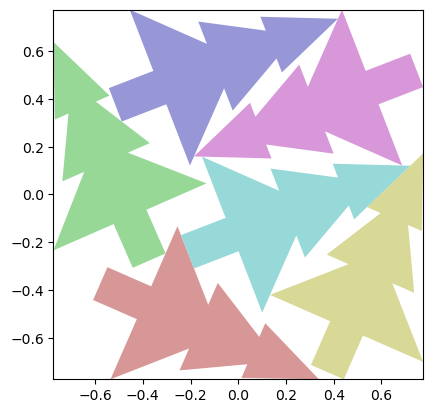

In [14]:
import pandas as pd
import pack_metric
import importlib
import copy
import numpy as np
import kaggle_support as kgs

importlib.reload(pack_metric)

cols = ['x', 'y', 'deg']
tree_list2 = copy.deepcopy(tree_list)
sc = 1.00004
tree_list2.x *= sc
tree_list2.y *= sc

print(tree_list2.xyt)
pack_vis.visualize_tree_list(tree_list2)

# Convert from centroid-centered coordinates back to original coordinates
# The centroid offset (cx, cy) was subtracted when recentering, so we add it back
# But we need to rotate the offset by each tree's angle first
cx, cy = kgs.tree_centroid_offset
cx,cy=-cx,-cy
print(cx,cy)
cos_theta = np.cos(tree_list2.theta)
sin_theta = np.sin(tree_list2.theta)
# Rotate the offset by each tree's angle and add to position
tree_list2.x += cx * cos_theta - cy * sin_theta
tree_list2.y += cx * sin_theta + cy * cos_theta

tree_list2.theta*=360/2/np.pi

n = tree_list2.xyt.shape[0]
submission = pd.DataFrame(
    index=[f'{n:03d}_{t}' for t in range(n)], columns=cols, data=tree_list2.xyt).rename_axis('id')
submission = submission.reset_index()

for col in cols:
    submission[col] = submission[col].astype(float).round(decimals=6)
    
# To ensure everything is kept as a string, prepend an 's'
for col in submission.columns:
    submission[col] = 's' + submission[col].astype('string')
submission
pack_metric.score(submission, submission, '', allow_error=False)

In [15]:
(0.4-0.3996)*200

0.08000000000000229